# TP OMA 1: First order methods for large scale regression

> ## RAMILISON Hugo | REGAIEG Mohamed

In this pratical exercise, we will train a linear regression model using first order methods as seen in the lectures.
In general, linear regression model do not require to solve an optimization model as the solution can be derived by inverting the normal equations (if the problem has the right properties). However, in the large scale setting, the inversion of the system required in the normal equation is not possible and approximate solutions are computeed using first order methods.

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2=\frac{1}{2n}\displaystyle\sum_{i=1}^n(a_i^\top x -b_i)^2$$

One can see the function $f$ is $\mu$ strongly convex with $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L$ smooth with $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$, since here the Hessian matrix is constant, independent of $x$.

When $A^{T} A$ is invertible, which is the case here, then we have a simple closed form solution for (the unique) $x^* = \text{argmin}_{x \in \mathbb{R}^d} f(x)$. Indeed, solving $\nabla f(x^*) = 0$ leads to $x^* = (A^T A)^{-1} A^T b$. However when $n$ and $d$ are large (which is the case in modern "big data" problems), using this formula is prohibitively expensive from a computational viewpoint, hence the necessity of using first order optimization algorithms.

In the examples used in the following, whenever possible, in order to exhibit the convergence rates, we will also compute 𝑓(𝑥∗) using the normal equations ($𝑥^∗=(𝐴^𝑇 𝐴)^{−1}𝐴^𝑇 𝑏)$. 

Additionally, we will also consider regularized version of the least square problem in order to enforce some structure in the solution as seen in the lecture as well (ex: L1 regulatrisation for sparsity, L2 for robustness to data perturbation,...).

We will first load some useful packages:

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import sklearn as sk
from sklearn.datasets import make_regression

## Generating data

In order to generate regression datasets, we will use a dataset generation function from the wellknown $\texttt{scikit-learn}$ machine learning python environment. The function documentation is available at  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html.

Create (by filling in the code below) a python function that will apply this function in order generate a datasets of $n$ samples of dimension $d$ (number of features).


In [36]:
def generate_dataset(n,d):
    X,Y = make_regression(n, d, n_informative=100, bias=2, coef=False, noise=10.0,random_state=1)
    return X,Y

In [37]:
n=1000
d=100


X,Y=generate_dataset(n,d)
print(f"Number of samples: {n}")
print(f"Number of features: {d}")
print("X=",X)
print("Y=",Y)

A = np.c_[np.ones(n), X]


Number of samples: 1000
Number of features: 100
X= [[ 0.54388479 -0.06835299  0.35931907 ... -0.27375108 -0.9766115
  -0.81551607]
 [ 1.18372719  0.28982301  1.36999833 ... -0.25693591  0.68151479
  -1.34058922]
 [-0.26874365  0.27742379  0.04919037 ...  1.57390016 -1.07297349
  -1.5335487 ]
 ...
 [-0.45026897  0.6951639   0.33162952 ... -0.10780022  0.37213536
  -0.32577564]
 [ 0.81339708  0.64209946 -0.77231855 ...  2.26288921 -0.60404811
   0.33245633]
 [-0.53788036 -1.08675775  0.61632466 ...  1.08582807  0.72157706
   0.24852872]]
Y= [ 1.60321600e+03  8.39498315e+02  9.27681963e+01  9.78522695e+01
 -4.69659428e+02  5.21195246e+01 -4.07988533e+02  5.71185386e+02
 -9.83336039e+01 -1.93962606e+01 -1.92337969e+02 -3.37113729e+02
  4.99449910e+00  4.36407175e+02 -5.58362825e+01 -1.19412093e+03
  6.85286595e+01  5.76910601e+02 -7.85275709e+02  3.85637829e+02
 -4.74931606e+02  8.56395335e+02  2.99090694e+01 -1.25776722e+02
  3.80142122e+02  6.85888593e+02 -7.92342670e+02  6.67258202e+02


In [38]:
# Define problem constants
eigenvalues, eigenvectors = np.linalg.eig(A.T @ A)  
mu = 1/(n)* np.min(eigenvalues)
L= 1/(n)* np.max(eigenvalues)


## Computing $f(x^*)$

In [39]:
def full_objective(Y, A, x):
    # Compute the least squares objective over the whole dataset
    return (1/(2*n))*np.linalg.norm(Y - A@x)**2

In [40]:
x_star = np.linalg.solve(A.T@A, A.T@Y)
best_objective = full_objective(Y, A, x_star)
print("f(x*) = ", best_objective)

f(x*) =  43.287435267228915


## Gradient descent

Let us first define the gradient function that will be used next in the descent algorithm.

In [41]:
def gradient_regression(Y, A, x):
    """
    Compute the gradient of the regression function for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    
    :return: gradient: numpy array of shape (d)
    """
    grad = (-1/n) * np.dot(A.T, (Y - A@x))
    return grad

Using your gradient function, propose an implementation of the gradient descent to solve the linear regression problem.

In [42]:
def gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, 
        lr,
        verbose=True
        ):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = x  - lr*grad 
    
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(Y, A, x)
        objectives.append(objective)
        if verbose:
            print("GD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                          bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your GD on the regression problem you have generated earlier. You may try several values for the step size.

In [43]:
import datetime

def solve_gd(nmax=1000, lr=0.1, verbose=True):
    # Initialization
    x_initial = np.zeros(A.shape[1])

    # Start GD
    print("---------Starting GD---------")
    print(f"Parameters: nmax={nmax}, lr={lr}")
    start_time = datetime.datetime.now()
    gd_objectives, gd_iterates = gradient_descent(Y, A, x_initial, nmax, lr, verbose=verbose)
    end_time = datetime.datetime.now()
    print("---------GD finished !---------")
    # Print result
    execution_time = (end_time - start_time).total_seconds()
    print("GD: execution time={t:.3f} seconds".format(t=execution_time))

    return gd_objectives, gd_iterates

gd_objectives, gd_iterates = solve_gd()

---------Starting GD---------
Parameters: nmax=1000, lr=0.1
GD(0000/0000/0999): objective =  134545.70
GD(0001/0001/0999): objective =  107122.90
GD(0002/0002/0999): objective =   85692.48
GD(0003/0003/0999): objective =   68865.15
GD(0004/0004/0999): objective =   55589.76
GD(0005/0005/0999): objective =   45067.73
GD(0006/0006/0999): objective =   36689.82
GD(0007/0007/0999): objective =   29989.21
GD(0008/0008/0999): objective =   24606.73
GD(0009/0009/0999): objective =   20264.77
GD(0010/0010/0999): objective =   16747.83
GD(0011/0011/0999): objective =   13887.91
GD(0012/0012/0999): objective =   11553.43
GD(0013/0013/0999): objective =    9640.91
GD(0014/0014/0999): objective =    8068.63
GD(0015/0015/0999): objective =    6771.76
GD(0016/0016/0999): objective =    5698.66
GD(0017/0017/0999): objective =    4808.03
GD(0018/0018/0999): objective =    4066.72
GD(0019/0019/0999): objective =    3448.00
GD(0020/0020/0999): objective =    2930.27
GD(0021/0021/0999): objective =    24

Let us now plot the convergence profile, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:

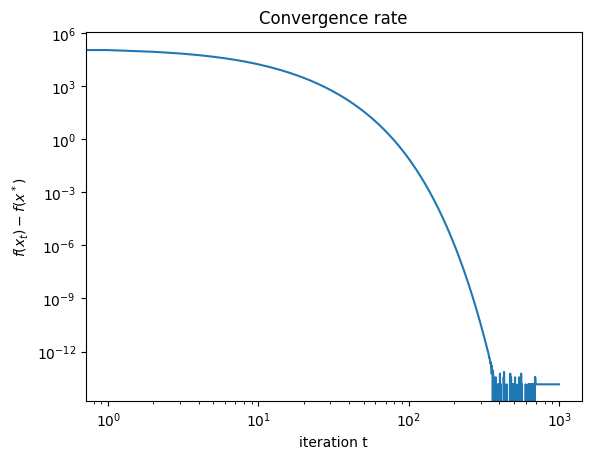

In [44]:
plt.title('Convergence rate')
plt.loglog(gd_objectives - best_objective)
plt.xlabel('iteration t')
plt.ylabel(r'$f(x_t) - f(x^*)$')
plt.show()

We can see that after the 300th iteration, the value of the error is way below numerical zero so the convergence is empirically verified for standard gradient descent.

One could wonder what is the best possible learning rate $\alpha^*$, it is theoritically given by the following formula:

$$
\begin{align*}
    \alpha^* = \frac{1}{L} = \frac{n}{\lambda_{max} (A^T A)}
\end{align*}
$$

In [45]:
lr_best = 1/L  # theoretical best lr
print(f"Theoriticall optimal laerning rate: {lr_best:.2f}")

Theoriticall optimal laerning rate: 0.58


---------Starting GD---------
Parameters: nmax=1000, lr=0.001
---------GD finished !---------
GD: execution time=0.046 seconds
---------Starting GD---------
Parameters: nmax=1000, lr=0.01
---------GD finished !---------
GD: execution time=0.040 seconds
---------Starting GD---------
Parameters: nmax=1000, lr=1.0
---------GD finished !---------
GD: execution time=0.040 seconds
---------Starting GD---------
Parameters: nmax=1000, lr=0.5779735359095682
---------GD finished !---------
GD: execution time=0.052 seconds


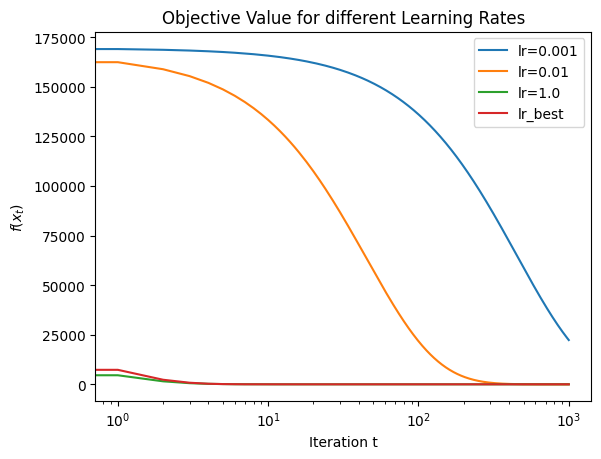

In [46]:
# Lr tuning
lr_values = [0.001, 0.01, 1.0, lr_best]
objectives_dict = {}
for lr in lr_values:
    objectives, _ = solve_gd(lr= lr, verbose=False)
    objectives_dict[lr] = objectives

for lr, objectives in objectives_dict.items():
    if lr==lr_best:
        plt.plot(objectives, label=f"lr_best")
    else:
        plt.plot(objectives, label=f"lr={lr}")
plt.legend()
plt.xlabel("Iteration t")
plt.xscale('log')
plt.ylabel(r'$f(x_t)$')
plt.title("Objective Value for different Learning Rates")
plt.show()

In [47]:
# displaying divergence for bigger lr
gd_infobjectives, _ = solve_gd(lr=1.2)

---------Starting GD---------
Parameters: nmax=1000, lr=1.2
GD(0000/0000/0999): objective =   41437.50
GD(0001/0001/0999): objective =   25151.33
GD(0002/0002/0999): objective =   19248.72
GD(0003/0003/0999): objective =   16296.29
GD(0004/0004/0999): objective =   14727.19
GD(0005/0005/0999): objective =   13990.79
GD(0006/0006/0999): objective =   13837.97
GD(0007/0007/0999): objective =   14144.26
GD(0008/0008/0999): objective =   14848.17
GD(0009/0009/0999): objective =   15924.71
GD(0010/0010/0999): objective =   17372.72
GD(0011/0011/0999): objective =   19208.42
GD(0012/0012/0999): objective =   21462.10
GD(0013/0013/0999): objective =   24176.68
GD(0014/0014/0999): objective =   27407.26
GD(0015/0015/0999): objective =   31221.55
GD(0016/0016/0999): objective =   35700.77
GD(0017/0017/0999): objective =   40941.11
GD(0018/0018/0999): objective =   47055.55
GD(0019/0019/0999): objective =   54176.18
GD(0020/0020/0999): objective =   62456.95
GD(0021/0021/0999): objective =   720

We checked empirically the optimality of the best learning rate which has the best convergence rate. While tuning, one must be wary of choosing a learning rate not to small, otherwise the convergence might end up to slow as seen in the graph above where for a $\alpha=0.001$ the convergence is still not met after 1000 iterations. But to big of a learning rate might cause the iterate to jump around the solution and even end up diverging as seen when choosing $\alpha=1.2$.

## Gradient descent acceleration

We will try now to converge faster using the gradient acceleration. Recall the acceleration scheme that adds a momentum term in the update:
$$
x_{k+1}=x_k-\alpha_k\nabla f(x_k) +\beta_k(x_k-x_{k-1})
$$
with $\alpha_k=\frac{4}{(\sqrt{L}+\sqrt{\mu})^2}$ and $\beta_k=\frac{\sqrt{L}-\sqrt{\mu}}{\sqrt{L}+\sqrt{\mu}}$
and $\mu=\lambda_{min}(\nabla^2 f(x))=\frac{1}{n}\lambda_{min}(A^T A)$ and $L=\lambda_{max}(\nabla^2 f(x))=\frac{1}{n}\lambda_{max}(A^T A)$.

Based on the gradient descent function you have written above, write a new accelerated gradient function:

In [48]:
# AGD constants
alpha = 4/ (math.sqrt(L) + math.sqrt(mu))**2
beta = (math.sqrt(L) - math.sqrt(mu)) / (math.sqrt(L) + math.sqrt(mu))

In [49]:
def accelerated_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax,
        lr,
        mom,
        verbose=True
        ):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate
    :param mom: momentum parameter
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    
    x = initial_x
    x_prev = initial_x
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        x_new = x -  lr* grad + mom* (x - x_prev)

        xs.append(x_new.copy())
        objective = full_objective(Y, A, x_new)
        objectives.append(objective)

        if verbose:
            print(f"AGD({epoch:04d}/{epoch:04d}/{n-1:04d}): objective = {objective:10.2f}")

        # Update for next iteration
        x_prev, x = x, x_new
    return objectives, xs

Test now your accelerated GD on the regression problem you have generated earlier.

In [50]:
import datetime

# Define the parameters of the algorithm.
def solve_gd_acc(nmax=1000, lr=0.1, mom=0.9, verbose=True):
    # Initialization
    x_initial = np.zeros(A.shape[1])

    # Start AGD
    print("---------Starting AGD---------")
    print(f"Parameters: nmax={nmax}, lr={lr:.3f}, mom={mom:.3f}")
    start_time = datetime.datetime.now()
    gd_objectives_acc, gd_iterates_acc = accelerated_gradient_descent(Y, A, x_initial, nmax, lr, mom, verbose)
    end_time = datetime.datetime.now()
    print("---------AGD finished !---------")

    # Print result
    execution_time = (end_time - start_time).total_seconds()
    print("AGD: execution time={t:.3f} seconds".format(t=execution_time))

    return gd_objectives_acc, gd_iterates_acc

# We straight away used the best hyperparameters
gd_objectives_acc, gd_iterates_acc = solve_gd_acc(lr=alpha, mom=beta)

---------Starting AGD---------
Parameters: nmax=1000, lr=0.989, mom=0.308
AGD(0000/0000/0999): objective =   17430.12
AGD(0001/0001/0999): objective =   10935.81
AGD(0002/0002/0999): objective =    3382.88
AGD(0003/0003/0999): objective =     859.25
AGD(0004/0004/0999): objective =     353.54
AGD(0005/0005/0999): objective =     126.33
AGD(0006/0006/0999): objective =      72.74
AGD(0007/0007/0999): objective =      50.78
AGD(0008/0008/0999): objective =      46.26
AGD(0009/0009/0999): objective =      43.99
AGD(0010/0010/0999): objective =      43.54
AGD(0011/0011/0999): objective =      43.37
AGD(0012/0012/0999): objective =      43.31
AGD(0013/0013/0999): objective =      43.30
AGD(0014/0014/0999): objective =      43.29
AGD(0015/0015/0999): objective =      43.29
AGD(0016/0016/0999): objective =      43.29
AGD(0017/0017/0999): objective =      43.29
AGD(0018/0018/0999): objective =      43.29
AGD(0019/0019/0999): objective =      43.29
AGD(0020/0020/0999): objective =      43.29
AG

Plot the convergence profile together with the previous plot to emphasize the acceleration, i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$:

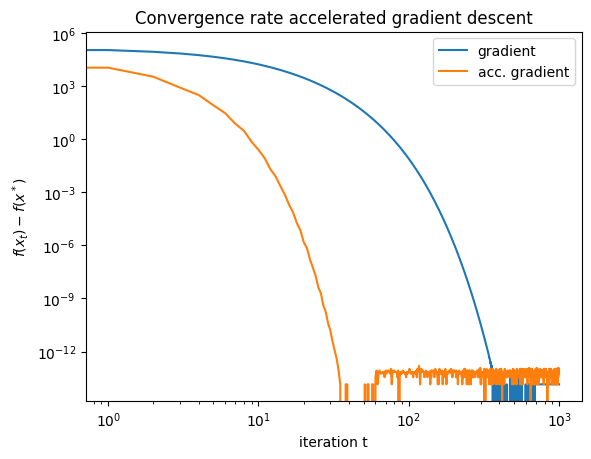

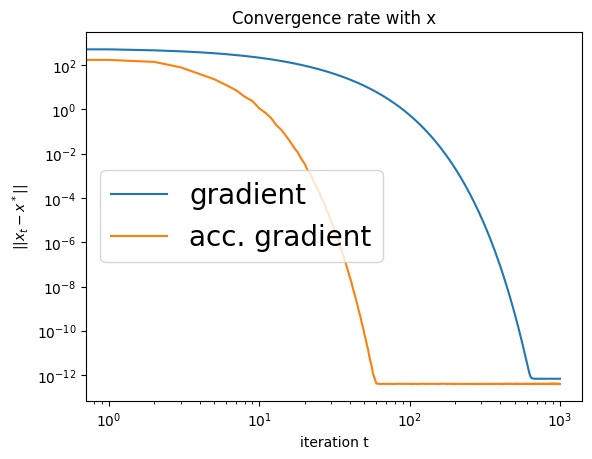

In [51]:
plt.figure(1)
plt.title('Convergence rate comparaison')
plt.loglog(gd_objectives - best_objective,label = r'gradient')
plt.xlabel('iteration t')
plt.ylabel(r'$f(x_t) - f(x^*)$')
plt.title('Convergence rate accelerated gradient descent')
plt.loglog(gd_objectives_acc - best_objective,label = r'acc. gradient')
plt.xlabel('iteration t')
plt.ylabel(r'$f(x_t) - f(x^*)$')

plt.legend()

plt.show()
# Plot convergence rate with x
plt.figure(2)
plt.title('Convergence rate with x')
plt.loglog([np.linalg.norm(x - x_star) for x in gd_iterates],label = r'gradient')
plt.loglog([np.linalg.norm(x - x_star) for x in gd_iterates_acc],label = r'acc. gradient')
plt.xlabel('iteration t')
plt.ylabel(r'$||x_t - x^*||$')
plt.legend(fontsize = 20)


Testing lr=0.001
---------Starting AGD---------
Parameters: nmax=1000, lr=0.001, mom=0.308
---------AGD finished !---------
AGD: execution time=0.049 seconds
Testing lr=0.01
---------Starting AGD---------
Parameters: nmax=1000, lr=0.010, mom=0.308
---------AGD finished !---------
AGD: execution time=0.042 seconds
Testing lr=0.1
---------Starting AGD---------
Parameters: nmax=1000, lr=0.100, mom=0.308
---------AGD finished !---------
AGD: execution time=0.043 seconds


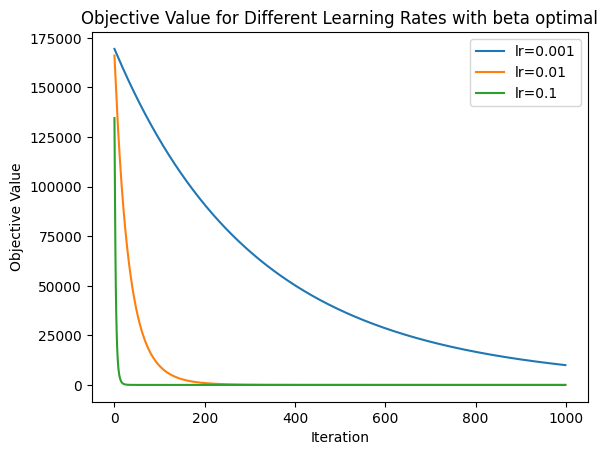

In [52]:
lr_values = [0.001, 0.01, 0.1]
objectives_dict_acc = {}
for lr in lr_values:
    print(f"Testing lr={lr}")
    objectives_acc, _ = solve_gd_acc(lr=lr, mom=beta, verbose=False)
    objectives_dict_acc[lr] = objectives_acc
for lr, objectives in objectives_dict_acc.items():
    plt.plot(objectives, label=f"lr={lr}")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.title("Objective Value for Different Learning Rates with beta optimal")
plt.show()
    

Testing mom=0.0
---------Starting AGD---------
Parameters: nmax=1000, lr=0.100, mom=0.000
---------AGD finished !---------
AGD: execution time=0.050 seconds
Testing mom=0.7
---------Starting AGD---------
Parameters: nmax=1000, lr=0.100, mom=0.700
---------AGD finished !---------
AGD: execution time=0.044 seconds
Testing mom=1.0
---------Starting AGD---------
Parameters: nmax=1000, lr=0.100, mom=1.000
---------AGD finished !---------
AGD: execution time=0.042 seconds


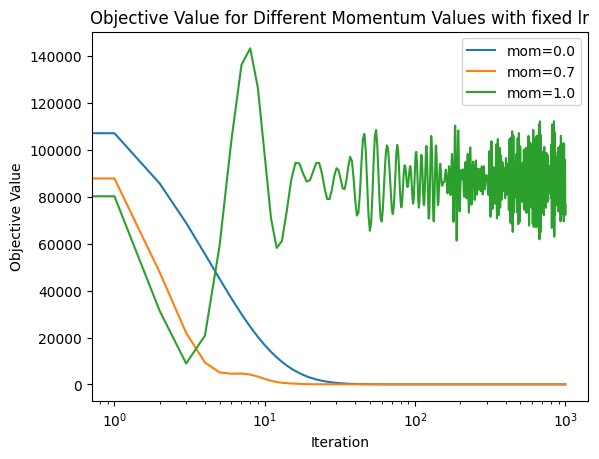

In [53]:
objectives_dict_acc = {}
mom_values = [0.0, 0.7, 1.0]
for mom in mom_values:
    print(f"Testing mom={mom}")
    objectives_acc, _ = solve_gd_acc(lr=0.1, mom=mom, verbose=False)
    objectives_dict_acc[mom] = objectives_acc

for mom, objectives in objectives_dict_acc.items():
    plt.plot(objectives_dict_acc[mom], label=f"mom={mom}")
plt.legend()
plt.xlabel("Iteration")
plt.xscale('log')
plt.ylabel("Objective Value")
plt.title("Objective Value for Different Momentum Values with fixed lr")
plt.show()   

The conclusions regarding the learning rate tuning are similar to the standard gradient descent.

Concerning the momentum tuning (parameter $\beta$) we can interpret it as a percentage of the previous step taken in the previous iteration. If it is null, we revert back to the basic gradient descent. However if it is to big (for instance taking 100% of the previous step size), we end up having an unstable algorithm. The theory finds out that the optimal momentum is around 30% of the previous step

## Subgradient descent for the $L_1$ regularized regression problem (LASSO)

Consider now the LASSO problem where we have added a $L_1$ regularization term. The problem is no longer differentiable and we propose to use a subgradient technique to solve it:

Given a matrix $A\in\mathbb{R}^{n\times d}$ and $b\in\mathbb{R}^n$, we want to minimize the following objective function

$$f(x)=\frac{1}{2n}\|Ax-b\|^2 + \lambda \|x\|_{1}$$

where $\lambda>0$ is an hyperparameter.



Write first a new routine for the objective function

In [54]:
def reg_objective(Y, A, x,lbda):
    # Compute the least squares objective over the whole dataset
    return (1/(2*len(A)))*np.linalg.norm(Y - A@x)**2 + lbda*np.linalg.norm(x, ord=1)

Write a subgradient function that will return a subgradient of $f$.

In [55]:
def subgradient_LASSO(Y, A, x, lbda):
    """
    Compute a subgradient of the LASSO problem for the entire dataset.
    
    :param Y: a numpy array of shape (n)
    :param A: a numpy array of shape (n, d)
    :param x: compute the gradient at these parameters, numpy array of shape (d)
    :param lbda: a positive scalar
    
    :return: subgradient: numpy array of shape (d)
    """
    
    return gradient_regression(Y, A, x) + lbda * np.sign(x)

Using your subgradient function, propose an implementation of the subgradient descent with constant step size to solve the linear regression problem.

In [56]:
def subgradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, 
        lr, 
        lbda,
        verbose=True
        ):
    """
    Subgradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param lbda: a positive scalar
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    best_obj=reg_objective(Y,A,initial_x,lbda)
    
    for epoch in range(nmax):
        subgrad = subgradient_LASSO(Y, A, x, lbda)
        # update x through the subgradient update

        x = x - lr*subgrad

        # store x and objective
        xs.append(x.copy())
        objective = reg_objective(Y, A, x,lbda)
        if objective<best_obj:
            best_obj=objective           
        objectives.append(best_obj)
        if verbose:
            print("subGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                        bi=epoch, ti=len(Y) - 1, l=best_obj))
    return objectives, xs

Test now your Sub-GD on the regression problem you have generated earlier. You may try several values for the step size.

In [57]:
import datetime

def solve_lasso(nmax=1000, lr=0.1, lbda=10, verbose=True):
    # Initialization
    x_initial = np.zeros(A.shape[1])

    # Start GD
    print("---------Starting subGD---------")
    print(f"Parameters: nmax={nmax}, lr={lr}, lbda={lbda}")
    start_time = datetime.datetime.now()
    subgd_objectives, subgd_iterates = subgradient_descent(
        Y, A, x_initial, nmax, lr,lbda, verbose=verbose)
    end_time = datetime.datetime.now()
    print("---------subGD finished !---------")
    # Print result
    execution_time = (end_time - start_time).total_seconds()
    print("subGD: execution time={t:.3f} seconds".format(t=execution_time))

    return subgd_objectives, subgd_iterates

subgd_objectives, subgd_iterates = solve_lasso()

---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=10
subGD(0000/0000/0999): objective =  139755.09
subGD(0001/0001/0999): objective =  120072.91
subGD(0002/0002/0999): objective =  104671.02
subGD(0003/0003/0999): objective =   92586.57
subGD(0004/0004/0999): objective =   83048.89
subGD(0005/0005/0999): objective =   75512.76
subGD(0006/0006/0999): objective =   69495.97
subGD(0007/0007/0999): objective =   64745.02
subGD(0008/0008/0999): objective =   60904.64
subGD(0009/0009/0999): objective =   57832.79
subGD(0010/0010/0999): objective =   55348.45
subGD(0011/0011/0999): objective =   53328.52
subGD(0012/0012/0999): objective =   51713.18
subGD(0013/0013/0999): objective =   50376.43
subGD(0014/0014/0999): objective =   49305.51
subGD(0015/0015/0999): objective =   48405.35
subGD(0016/0016/0999): objective =   47672.78
subGD(0017/0017/0999): objective =   47085.49
subGD(0018/0018/0999): objective =   46592.58
subGD(0019/0019/0999): objective =   46172.26
subGD(00

Let us now plot the convergence profile, i.e. $f(x_t)$ with respect to the iteration $t$:

---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=0.01
---------subGD finished !---------
subGD: execution time=0.056 seconds
GD: execution time=0.056 seconds
---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=0.1
---------subGD finished !---------
subGD: execution time=0.048 seconds
GD: execution time=0.048 seconds
---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=1
---------subGD finished !---------
subGD: execution time=0.048 seconds
GD: execution time=0.048 seconds
---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=10
---------subGD finished !---------
subGD: execution time=0.045 seconds
GD: execution time=0.046 seconds
---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=50
---------subGD finished !---------
subGD: execution time=0.045 seconds
GD: execution time=0.045 seconds
---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=100
---------subGD finished !---------
subGD: exe

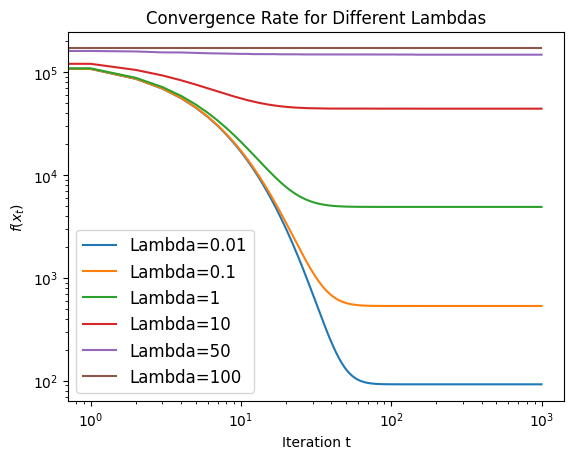

In [58]:
lbda_list = [0.01,0.1,1, 10, 50, 100]
for lbda in lbda_list:
    start_time = datetime.datetime.now()
    subgd_objectives, subgd_iterates = solve_lasso(lbda=lbda, verbose=False)
    end_time = datetime.datetime.now()
    plt.loglog(subgd_objectives, label=f'Lambda={lbda}')
    # Print result
    execution_time = (end_time - start_time).total_seconds()
    print("GD: execution time={t:.3f} seconds".format(t=execution_time))
    plt.xlabel('Iteration t')
    plt.ylabel(r'$f(x_t)$')
    plt.title('Convergence Rate for Different Lambdas')
    plt.legend(fontsize=12)
plt.show()

Lambda acts as a penalisation, the bigger the lambda, the farther away from the objective we are

Propose a mean to check or visualize whether the solution of the LASSO is sparser (numerically speaking since zero coordinates may not be achieved) than the solution of the regression problem:

---------Starting subGD---------
Parameters: nmax=1000, lr=0.1, lbda=10
subGD(0000/0000/0999): objective =  139755.09
subGD(0001/0001/0999): objective =  120072.91
subGD(0002/0002/0999): objective =  104671.02
subGD(0003/0003/0999): objective =   92586.57
subGD(0004/0004/0999): objective =   83048.89
subGD(0005/0005/0999): objective =   75512.76
subGD(0006/0006/0999): objective =   69495.97
subGD(0007/0007/0999): objective =   64745.02
subGD(0008/0008/0999): objective =   60904.64
subGD(0009/0009/0999): objective =   57832.79
subGD(0010/0010/0999): objective =   55348.45
subGD(0011/0011/0999): objective =   53328.52
subGD(0012/0012/0999): objective =   51713.18
subGD(0013/0013/0999): objective =   50376.43
subGD(0014/0014/0999): objective =   49305.51
subGD(0015/0015/0999): objective =   48405.35
subGD(0016/0016/0999): objective =   47672.78
subGD(0017/0017/0999): objective =   47085.49
subGD(0018/0018/0999): objective =   46592.58
subGD(0019/0019/0999): objective =   46172.26
subGD(00

Text(0.5, 1.0, 'Comparison of GD and subGD solutions values')

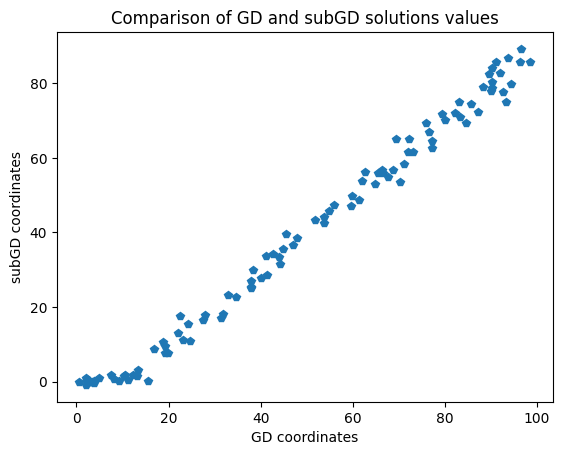

In [59]:
subgd_objectives, subgd_iterates = solve_lasso()
plt.plot(gd_iterates[-1], subgd_iterates[-1], 'p')
plt.xlabel("GD coordinates")
plt.ylabel("subGD coordinates")
plt.title("Comparison of GD and subGD solutions values")

The first 20 coordinates are null, which confirms the sparsity of the LASSO solution.

## Proximal gradient descent for the 𝐿1 regularized regression problem (LASSO)

We will now the same problem as before using the proximal gradient algorithm specifically designed for composite functions (one smooth term and one possibly non differentiable term). We recall proximal gradient update:
$$x_{k+1}=prox_{\alpha_k h}\left\{x_k-\alpha_k \nabla g(x_k)\right\}$$
where $g$ is the function such that $g(x)=\|Ax-b\|^2$ and $h$ such that $h(x)=\lambda\|x\|_1$.

Write a prox function that will return $prox_{\alpha \lambda\|.\|_1}$. Recall that the proximal operator is given by $prox_{\alpha \lambda\|.\|}$ is such that:
$$
\left(\operatorname{prox}_{\alpha \lambda \|\cdot\|_1}(x)\right)_i =
\begin{cases}
x_i - \alpha \lambda, & \text{si } x_i > \alpha \lambda, \\[4pt]
0, & \text{si } |x_i| \le \alpha \lambda, \\[4pt]
x_i + \alpha \lambda, & \text{si } x_i < -\alpha \lambda,
\end{cases}
\qquad \forall i = 1, \dots, d.
$$

In [60]:
def prox_L1(v,alpha):
    d= v.shape[0]
    prox_vec = np.zeros(d)
    for i in range(d):
        if v[i] > alpha:
            prox_vec[i] = v[i] - alpha
        elif v[i] < -alpha:
            prox_vec[i] = v[i] + alpha
        else:
            prox_vec[i] = 0
    return prox_vec

Using your proximal operator, propose an implementation of the proximal gradient descent with constant step size to solve the linear regression problem:

In [61]:
def prox_gradient_descent(
        Y, 
        A, 
        initial_x, 
        nmax, lr,lbda,
        verbose=True):
    """
    Gradient Descent for Linear Least Squares problems.
    
    :param Y: numpy array of size (n)
    :param A: numpy array of size (n, d)
    :param initial_x: starting parameters, a numpy array of size (d)
    :param nmax: integer, number of iterations
    :param lr: learning rate=step size
    :param lbda positive scalar
    
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for epoch in range(nmax):
        grad = gradient_regression(Y, A, x)
        # update x through the gradient update
        x = prox_L1(x - lr * grad, lr * lbda)
        # store x and objective
        xs.append(x.copy())
        objective = reg_objective(Y, A, x,lbda)
        objectives.append(objective)
        if verbose:
            print("proxGD({ep:04d}/{bi:04d}/{ti:04d}): objective = {l:10.2f}".format(ep=epoch,
                      bi=epoch, ti=len(Y) - 1, l=objective))
    return objectives, xs

Test now your proximal gradient method on the regression problem you have generated earlier and compare it with the subgradient method. You may try several values for the step size.

In [62]:
import datetime

# Define the parameters of the algorithm.
nmax = 1000
lr=0.1
lbda=10

def solve_proxgd(nmax=1000, lr=0.1, lbda=10, verbose=True):
    # Initialization
    x_initial = np.zeros(A.shape[1])

    # Start GD
    print("---------Starting proxGD---------")
    print(f"Parameters: nmax={nmax}, lr={lr}, lbda={lbda}")
    start_time = datetime.datetime.now()
    proxgd_objectives, proxgd_iterates = prox_gradient_descent(Y, A, x_initial, nmax,lr,lbda, verbose=verbose)
    end_time = datetime.datetime.now()
    print("---------proxGD finished !---------")

    # Print result
    execution_time = (end_time - start_time).total_seconds()
    print("proxGD: execution time={t:.3f} seconds".format(t=execution_time))

    return proxgd_objectives, proxgd_iterates

proxgd_objectives, proxgd_iterates = solve_proxgd()

---------Starting proxGD---------
Parameters: nmax=1000, lr=0.1, lbda=10
proxGD(0000/0000/0999): objective =  143425.59
proxGD(0001/0001/0999): objective =  122911.04
proxGD(0002/0002/0999): objective =  106886.23
proxGD(0003/0003/0999): objective =   94312.67
proxGD(0004/0004/0999): objective =   84408.47
proxGD(0005/0005/0999): objective =   76575.22
proxGD(0006/0006/0999): objective =   70355.66
proxGD(0007/0007/0999): objective =   65398.14
proxGD(0008/0008/0999): objective =   61431.83
proxGD(0009/0009/0999): objective =   58245.75
proxGD(0010/0010/0999): objective =   55676.67
proxGD(0011/0011/0999): objective =   53597.40
proxGD(0012/0012/0999): objective =   51908.46
proxGD(0013/0013/0999): objective =   50532.55
proxGD(0014/0014/0999): objective =   49411.46
proxGD(0015/0015/0999): objective =   48493.33
proxGD(0016/0016/0999): objective =   47739.08
proxGD(0017/0017/0999): objective =   47117.85
proxGD(0018/0018/0999): objective =   46604.57
proxGD(0019/0019/0999): objective 

Plot the convergence profile together with the previous plot (subgradient) and compare (i.e. $f(x_t) - f(x^*)$ with respect to the iteration $t$):

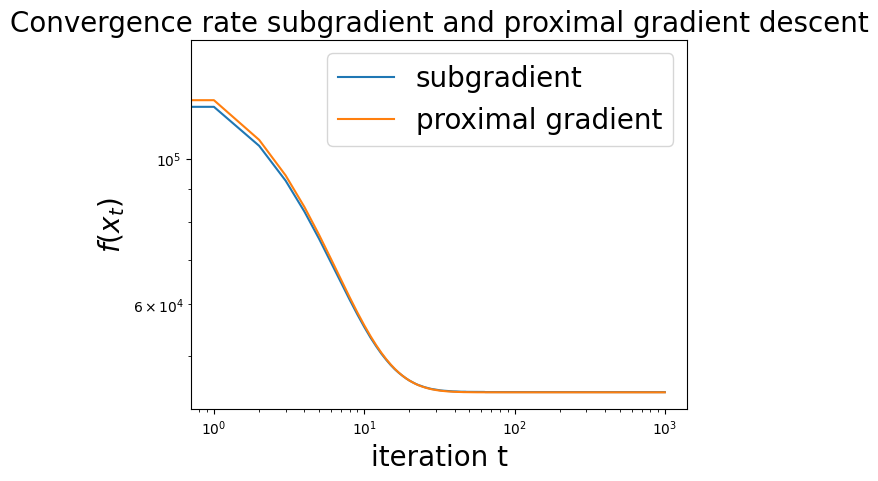

In [63]:
plt.figure(4)
plt.title('Convergence rate subgradient and proximal gradient descent', fontsize = 20)
plt.loglog(subgd_objectives,label = r'subgradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t)$', fontsize = 20)

plt.loglog(proxgd_objectives,label = r'proximal gradient')
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t)$', fontsize = 20)
plt.legend(fontsize = 20)


/tmp/ipykernel_36376/840818669.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize = 20)


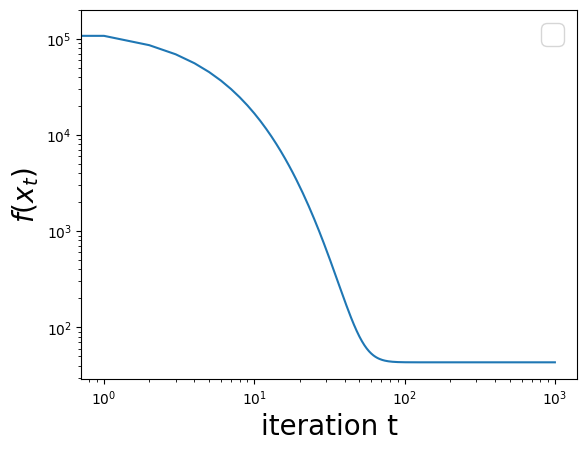

In [64]:
plt.loglog(gd_objectives)
plt.xlabel('iteration t'  , fontsize = 20)
plt.ylabel(r'$f(x_t)$', fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

As seen in the two graphs up above, the proximal and subgradient method do converge but much more slowly than the standard gradient method. As excpected since both are at most sub linear in terms of convergence.

Describe the experiments and comment the results from this notebook in your final report.

## Impact of the Dimension d and the Number of Observations n

### Impact of the Number of Observations $n$

---------Starting AGD---------
Parameters: nmax=1000, lr=0.989, mom=0.308
---------AGD finished !---------
AGD: execution time=0.099 seconds
(d=100) n=1000 | method=acc_gd | last objective=4.328744e+01
---------Starting AGD---------
Parameters: nmax=1000, lr=1.002, mom=0.138
---------AGD finished !---------
AGD: execution time=0.315 seconds
(d=100) n=5000 | method=acc_gd | last objective=4.700880e+01
---------Starting AGD---------
Parameters: nmax=1000, lr=1.000, mom=0.099
---------AGD finished !---------
AGD: execution time=0.685 seconds
(d=100) n=10000 | method=acc_gd | last objective=4.831526e+01
---------Starting AGD---------
Parameters: nmax=1000, lr=1.002, mom=0.044
---------AGD finished !---------
AGD: execution time=25.863 seconds
(d=100) n=50000 | method=acc_gd | last objective=4.971677e+01


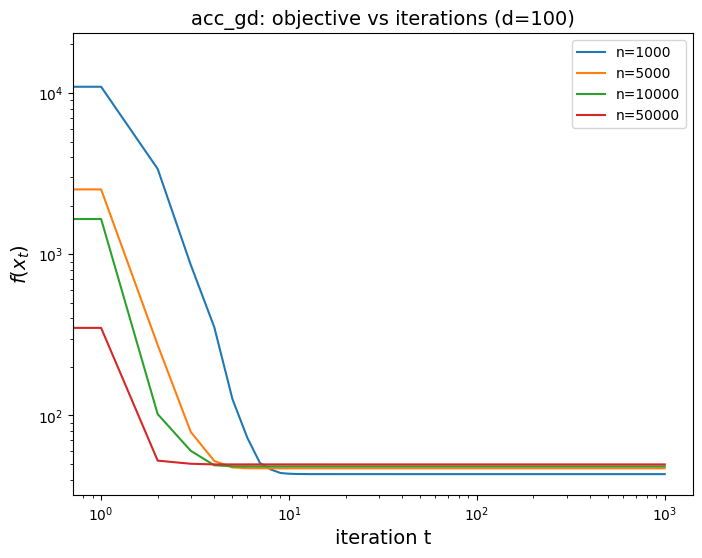

In [65]:
# Choose method type here:
# "gd", "acc_gd", "subgd", "proxgd"
method_type = "acc_gd"

# Fix d
d = 100
n_vector = [1000, 5000, 10000, 50000]

# Store objectives per n
objectives_dict = {}

for n in n_vector:
    # dataset with fixed d
    X, Y = generate_dataset(n, d)
    A = np.c_[np.ones(n), X]

    # For least squares: mu and L from Hessian
    eigenvalues, eigenvectors = np.linalg.eig(A.T @ A)  
    mu = 1/(n)* np.min(eigenvalues)
    L= 1/(n)* np.max(eigenvalues)
    # learning rates
    lr_gd = 1 / L
    alpha = 4 / ((np.sqrt(L) + np.sqrt(mu))**2)
    beta = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))

    # For LASSO methods: same lr for subGD and proxGD
    lr_lasso = lr_gd

    # Run selected method
    if method_type == "gd":
        obj, iters = solve_gd(nmax=1000, lr=lr_gd, verbose=False)

    elif method_type == "acc_gd":
        obj, iters = solve_gd_acc(nmax=1000, lr=alpha, mom=beta, verbose=False)

    elif method_type == "subgd":
        obj, iters = solve_lasso(nmax=1000, lr=lr_lasso, lbda=10, verbose=False)

    elif method_type == "proxgd":
        obj, iters = solve_proxgd(nmax=1000, lr=lr_lasso, lbda=10, verbose=False)

    else:
        raise ValueError('method_type must be one of: "gd", "acc_gd", "subgd", "proxgd"')

    objectives_dict[n] = obj
    print(f"(d={d}) n={n} | method={method_type} | last objective={obj[-1]:.6e}")

# Plot objective vs iterations (loglog)
plt.figure(figsize=(8, 6))
for n in n_vector:
    plt.loglog(objectives_dict[n], label=f"n={n}")

plt.xlabel("iteration t", fontsize=14)
plt.ylabel(r"$f(x_t)$", fontsize=14)
plt.title(f"{method_type}: objective vs iterations (d={d})", fontsize=14)
plt.legend()
plt.show()

### Impact of the Dimension $d$

---------Starting AGD---------
Parameters: nmax=1000, lr=0.998, mom=0.098
---------AGD finished !---------
AGD: execution time=0.024 seconds
(n=1000) d=10 | method=acc_gd | last objective=4.900787e+01
---------Starting AGD---------
Parameters: nmax=1000, lr=1.006, mom=0.216
---------AGD finished !---------
AGD: execution time=0.035 seconds
(n=1000) d=50 | method=acc_gd | last objective=4.783309e+01
---------Starting AGD---------
Parameters: nmax=1000, lr=0.989, mom=0.308
---------AGD finished !---------
AGD: execution time=0.076 seconds
(n=1000) d=100 | method=acc_gd | last objective=4.328744e+01
---------Starting AGD---------
Parameters: nmax=1000, lr=1.006, mom=0.442
---------AGD finished !---------
AGD: execution time=0.170 seconds
(n=1000) d=200 | method=acc_gd | last objective=4.483034e+01
---------Starting AGD---------
Parameters: nmax=1000, lr=1.002, mom=0.702
---------AGD finished !---------
AGD: execution time=13.060 seconds
(n=1000) d=500 | method=acc_gd | last objective=2.29

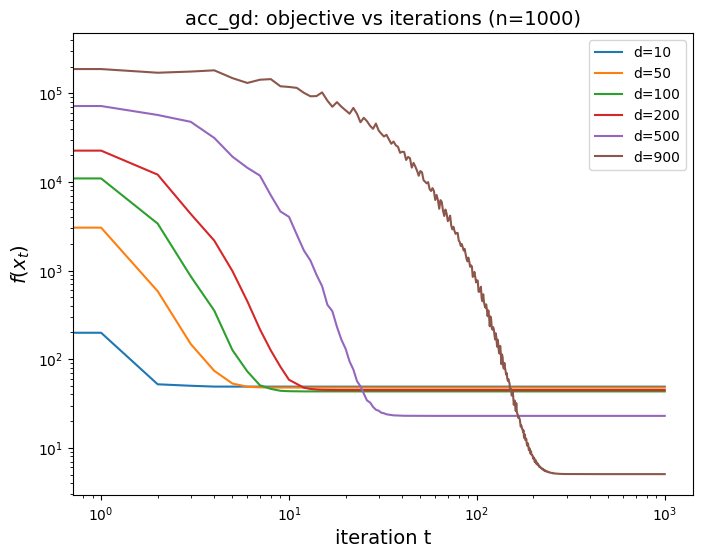

In [66]:
# Choose method type here:
# "gd", "acc_gd", "subgd", "proxgd"
method_type = "acc_gd"

# Fix n, vary d
n = 1000
d_vector = [10, 50, 100, 200, 500, 900]

# Store objectives per d
objectives_dict = {}

for d in d_vector:
    X, Y = generate_dataset(n, d)
    A = np.c_[np.ones(n), X]

    eigenvalues, eigenvectors = np.linalg.eig(A.T @ A)  
    mu = 1/(n)* np.min(eigenvalues)
    L= 1/(n)* np.max(eigenvalues)

    lr_gd = 1 / L
    alpha = 4 / ((np.sqrt(L) + np.sqrt(mu))**2)
    beta = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))

    lr_lasso = lr_gd

    if method_type == "gd":
        obj, iters = solve_gd(nmax=1000, lr=lr_gd, verbose=False)

    elif method_type == "acc_gd":
        obj, iters = solve_gd_acc(nmax=1000, lr=alpha, mom=beta, verbose=False)

    elif method_type == "subgd":
        obj, iters = solve_lasso(nmax=1000, lr=lr_lasso, lbda=10, verbose=False)

    elif method_type == "proxgd":
        obj, iters = solve_proxgd(nmax=1000, lr=lr_lasso, lbda=10, verbose=False)

    else:
        raise ValueError('method_type must be one of: "gd", "acc_gd", "subgd", "proxgd"')

    objectives_dict[d] = obj
    print(f"(n={n}) d={d} | method={method_type} | last objective={obj[-1]:.6e}")

# Plot objective vs iterations (loglog), legend = d
plt.figure(figsize=(8, 6))
for d in d_vector:
    plt.loglog(objectives_dict[d], label=f"d={d}")

plt.xlabel("iteration t", fontsize=14)
plt.ylabel(r"$f(x_t)$", fontsize=14)
plt.title(f"{method_type}: objective vs iterations (n={n})", fontsize=14)
plt.legend()
plt.show()